I will test the accuracy of the numerical integration vs discrete Fourier transform methods of calculating the convolution integral. 
In order to have a known analytical solution to the convolution I will convolve 2 Gamma distributions, as it holds that: 

$Gamma(\alpha_1, \beta)*Gamma(\alpha_1, \beta)= Gamma(\alpha_1 + \alpha_2, \beta)$

Where to stay in line with the notation used in scipy the PDF of the Gamma distribution is described as: 

$f(x, \alpha, \beta) = \frac{\beta^{\alpha} x^{\alpha -1}e^{-\beta x}}{\Gamma(\alpha)}$

($\beta$ is given as the inverse of the scale parameter)

I first read in all the packages that are needed. 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy.interpolate import interp1d
from scipy.stats import gamma
import time

from treetime.node_interpolator import NodeInterpolator
from treetime.distribution import Distribution
from treetime.config import BIG_NUMBER, TINY_NUMBER

Then I create two Distribution objects for two Gamma distributions, I additionally defien the analytical solution to their convolution.

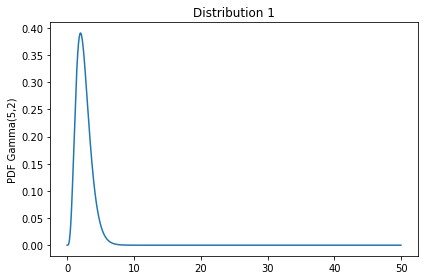

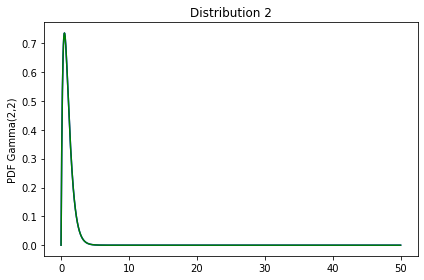

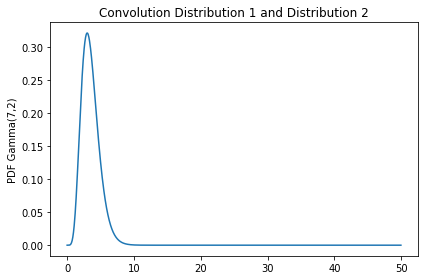

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [2]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

beta = 2
alpha_1 = 5
alpha_2 = 2

start = 0
end = 50
x = np.linspace(start, end, num=1000, endpoint=False) #create an x vector of points that should be sampled
y_1 = gamma.pdf(x, alpha_1, scale=1/beta)
y_1[y_1 == 0] = TINY_NUMBER ##remove -inf to prevent numerical errors

fig= plt.figure()
plt.autoscale()
plt.plot(x, gamma.pdf(x, alpha_1, scale=1/beta), label="PDF")
plt.ylabel("PDF Gamma("+ str(alpha_1) +","+str(beta)+ ")")
plt.title("Distribution 1")
plt.show()
dist_1 = Distribution(x, y_1, kind='linear', is_log=False)

y_2 = gamma.pdf(x, alpha_2, scale=1/beta)
y_2[y_2 == 0] = TINY_NUMBER ##remove -inf to prevent numerical errors

dist_2 = Distribution(x, y_2, kind='linear', is_log=False)

plt.figure()
plt.plot(x, gamma.pdf(x, alpha_2, scale=1/beta), color="blue")
plt.plot(x, np.exp(-dist_2.y), color="green") ##just to check that distribution object is initialized accurately 
plt.ylabel("PDF Gamma("+ str(alpha_2) +","+str(beta)+ ")")
plt.title("Distribution 2")
plt.show()


alpha_sol = alpha_1 + alpha_2
y_sol = gamma.pdf(x, alpha_sol, scale=1/beta)
y_sol[y_sol == 0] = TINY_NUMBER ##remove -inf to prevent numerical errors
dist_sol = Distribution(x, y_sol, kind='linear', is_log=False)
plt.figure()
plt.plot(x, gamma.pdf(x, alpha_sol, scale=1/beta))
plt.ylabel("PDF Gamma("+ str(alpha_sol) +","+str(beta)+ ")")
plt.title("Convolution Distribution 1 and Distribution 2")
plt.show()

plt.figure()

I shall now perform convolution on the two gamma distributions using the afore mentioned methods. I shall again vary the grid sizes used for convolution and see the effects on accuracy by comparing the output with the analytical solution.

In [3]:
def accuracy_and_time(calc_type, grid_size):
    if calc_type=="fft":
        start = time.process_time()
        res = NodeInterpolator.convolve_fft(dist_1, dist_2, fft_grid_size=int(grid_size/25))
        conv_time = time.process_time() - start
        true_grid_size = len(res.y)
    if calc_type=="num":
        start = time.process_time()
        res = NodeInterpolator.convolve(dist_1, dist_2, n_grid_points=grid_size, n_integral=grid_size)[0] ##second output is grid scale, which is also given in the x parameter
        conv_time = time.process_time() - start
        true_grid_size = len(res[0].y)
    return res, conv_time, true_grid_size

##in order to perform the convolution dist_2 needs a one_mutation parameter (as this should be a BranchLenInterpolator object)
dist_2.one_mutation = 0
        

I am not sure what exactly the impact of the one_mutation parameter is.

In [8]:
grid_size = [50, 100, 200, 300, 500, 1000] #more desired grid_sizes, true grid size is given as output when the accuracy_and_time function is called
time_fft = np.empty((len(grid_size),2))
accuracy_fft = []
time_num = np.empty((len(grid_size),2))
accuracy_num = []
for t in range(len(grid_size)):
    #print(t)
    time_fft_full = accuracy_and_time("fft", grid_size[t])
    time_fft[t] = time_fft_full[1:3]
    accuracy_fft.append(time_fft_full[0])
    time_num_full = accuracy_and_time("num", grid_size[t])
    time_num[t] = time_num_full[1:3]
    accuracy_num.append(time_num_full[0])


First I just plot the probability density functions to get a visual assessment of the accuracy.

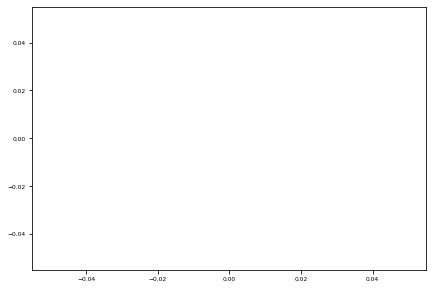

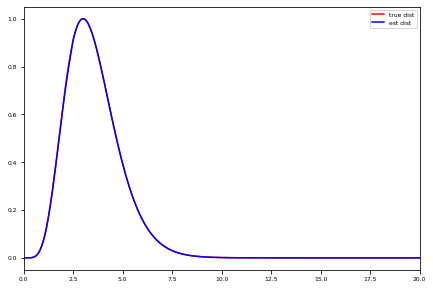

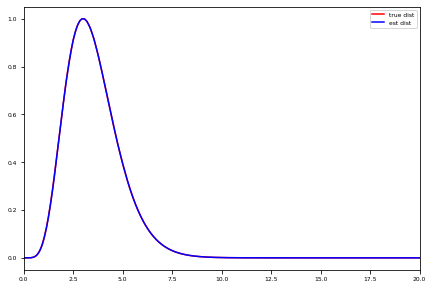

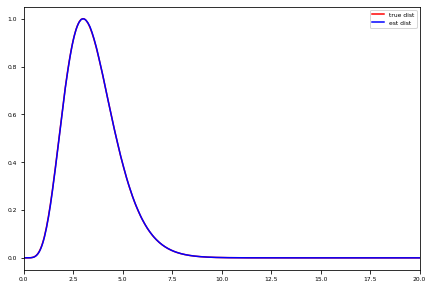

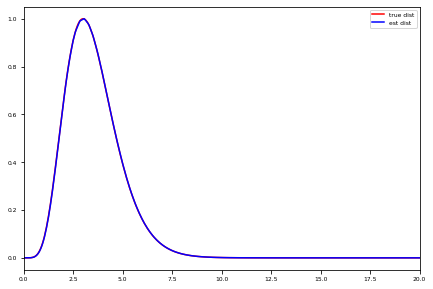

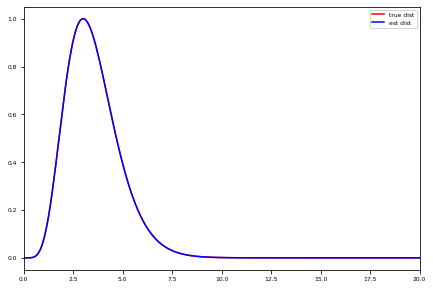

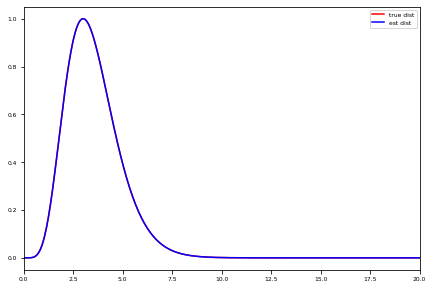

In [5]:
norm_y_sol = y_sol/max(y_sol)

epsilon = 1e-11
plt.rcParams['font.size'] = '6'
plt.autoscale()
fig.tight_layout()
for t in range(len(grid_size)):
    norm_y_est = np.exp(-accuracy_num[t][0](x))
    norm_y_est = norm_y_est/max(norm_y_est)
    plt.figure()
    plt.plot(x, norm_y_sol, color= "red", label="true dist")
    plt.plot(x, norm_y_est, color="blue", label="est dist")
    plt.legend()
    plt.xlim((0,20))

grid points (output):47.0


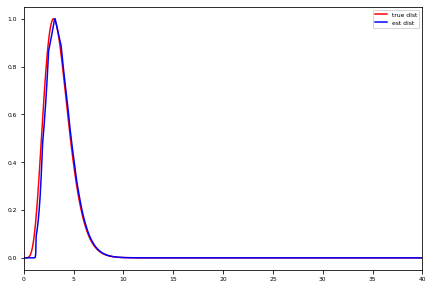

<Figure size 432x288 with 0 Axes>

grid points (output):86.0


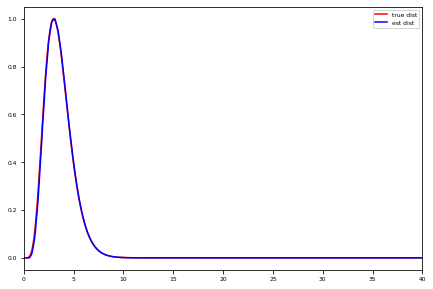

<Figure size 432x288 with 0 Axes>

grid points (output):164.0


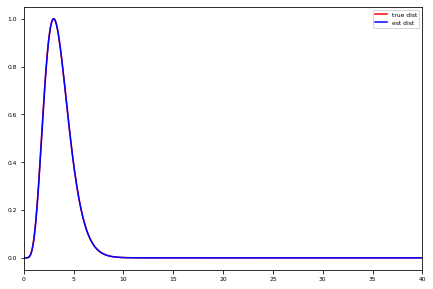

<Figure size 432x288 with 0 Axes>

grid points (output):241.0


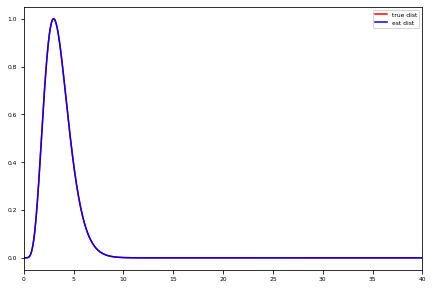

<Figure size 432x288 with 0 Axes>

grid points (output):395.0


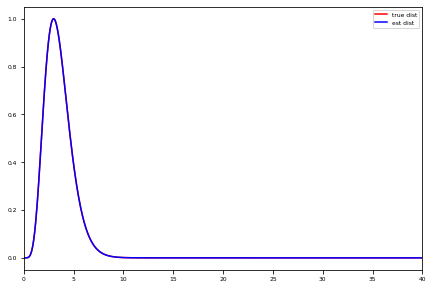

<Figure size 432x288 with 0 Axes>

grid points (output):782.0


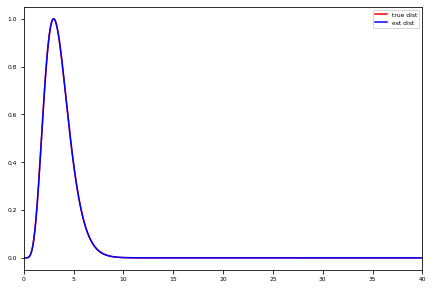

<Figure size 432x288 with 0 Axes>

In [6]:
for t in range(len(grid_size)):
    print("grid points (output):" +str(time_fft[t][1]))
    norm_y_est = np.exp(-accuracy_fft[t](x))
    norm_y_est = norm_y_est/max(norm_y_est)
    plt.figure()
    plt.plot(x, norm_y_sol, color= "red", label="true dist")
    plt.plot(x, norm_y_est, color="blue", label="est dist")
    plt.legend()
    plt.xlim((0,40))
    plt.figure()
    plt.show()

FFT grid points (output):47.0
NUM grid points (output):124.0


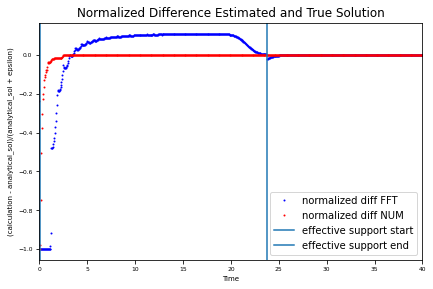

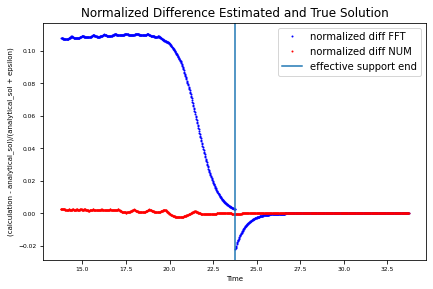

Absolute difference at end of effective support: 2.625315926668384e-14
Absolute difference at end plus epsilon of effective support: -2.33363621824074e-13
FFT grid points (output):86.0
NUM grid points (output):141.0


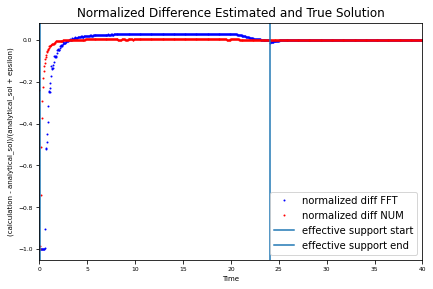

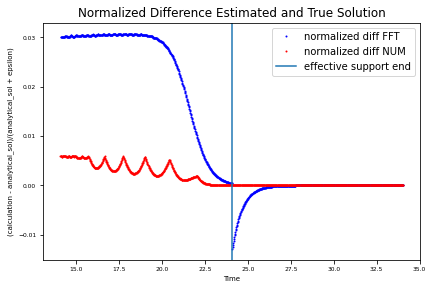

Absolute difference at end of effective support: 4.19495864901761e-15
Absolute difference at end plus epsilon of effective support: -1.351017108018891e-13
FFT grid points (output):164.0
NUM grid points (output):180.0


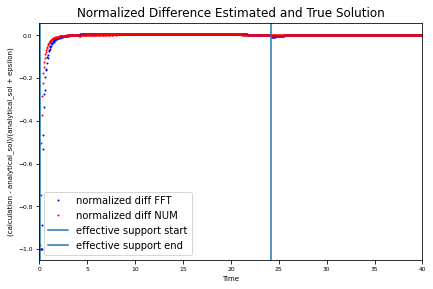

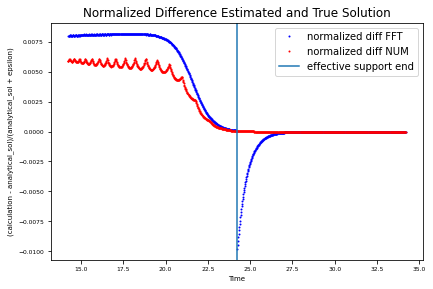

Absolute difference at end of effective support: 8.45682459354335e-16
Absolute difference at end plus epsilon of effective support: -1.0275653233142705e-13
FFT grid points (output):241.0
NUM grid points (output):237.0


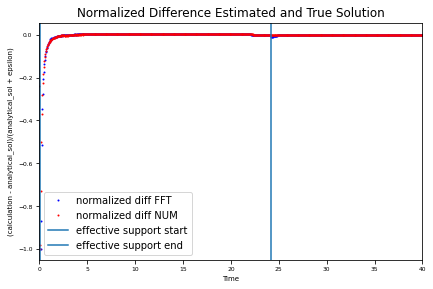

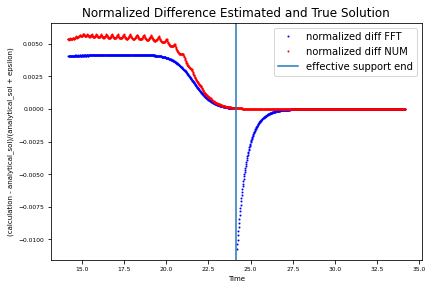

Absolute difference at end of effective support: 3.640179632947757e-16
Absolute difference at end plus epsilon of effective support: -1.1257415007131847e-13
FFT grid points (output):395.0
NUM grid points (output):336.0


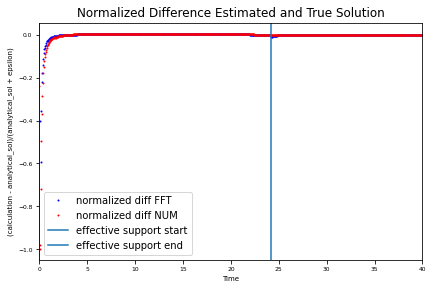

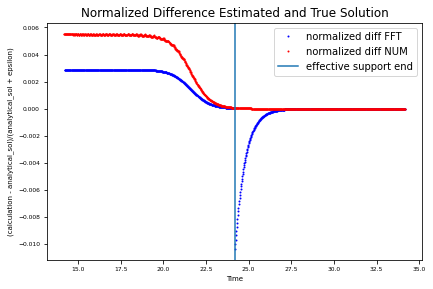

Absolute difference at end of effective support: 4.478378553114732e-16
Absolute difference at end plus epsilon of effective support: -1.0853970842168365e-13
FFT grid points (output):782.0
NUM grid points (output):583.0


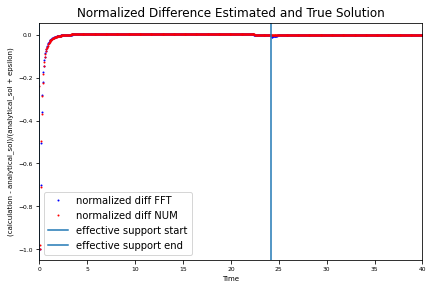

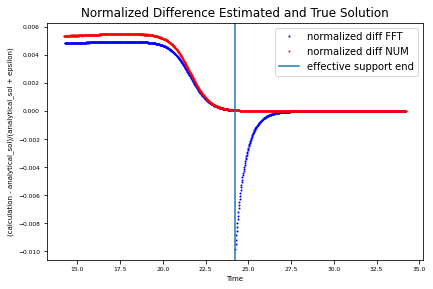

Absolute difference at end of effective support: 5.079087888918163e-16
Absolute difference at end plus epsilon of effective support: -1.0275653233142705e-13


In [23]:
def get_P(x, neg_log_P):
    #print(neg_log_P.peak_val)
    y = neg_log_P(x)
    y = np.exp(-y + neg_log_P.peak_val)
    return y

for t in range(len(grid_size)):
    print("FFT grid points (output):" +str(time_fft[t][1]))
    print("NUM grid points (output):" +str(time_num[t][1]))
    eff_support = accuracy_fft[t].effective_support
    norm_y_est_fft = get_P(x, accuracy_fft[t])
    norm_y_est_num = get_P(x, accuracy_num[t][0])
    plt.figure()
    plt.plot(x[2:], ((norm_y_est_fft -norm_y_sol)/(norm_y_sol+epsilon))[2:], 'o', markersize=1, color="blue", label="normalized diff FFT")
    plt.plot(x, (norm_y_est_num -norm_y_sol)/(norm_y_sol+epsilon), 'o', markersize=1, color="red", label="normalized diff NUM")
    plt.axvline(x=eff_support[0], label= "effective support start")
    plt.axvline(x=eff_support[1], label= "effective support end")
    plt.legend(prop={"size":10})
    plt.xlim((0,40))
    plt.ylabel("(calculation - analytical_sol)/(analytical_sol + epsilon)", fontsize=7)
    plt.xlabel("Time", fontsize=7)
    plt.title("Normalized Difference Estimated and True Solution", fontsize=12)
    plt.show()

    x_support = np.linspace(eff_support[1]-10, eff_support[1]+10, num=1000, endpoint=False) #create an x vector of points that should be sampled
    norm_y_sol_sup = get_P(x_support, dist_sol)
    norm_y_est_fft = get_P(x_support, accuracy_fft[t])
    norm_y_est_num = get_P(x_support, accuracy_num[t][0])  
    plt.figure()
    plt.plot(x_support[2:], ((norm_y_est_fft -norm_y_sol_sup)/(norm_y_sol_sup+epsilon))[2:], 'o', markersize=1, color="blue", label="normalized diff FFT")
    plt.plot(x_support, (norm_y_est_num -norm_y_sol_sup)/(norm_y_sol_sup+epsilon), 'o', markersize=1, color="red", label="normalized diff NUM")
    plt.ylabel("(calculation - analytical_sol)/(analytical_sol + epsilon)", fontsize=7)
    plt.xlabel("Time", fontsize=7)
    plt.title("Normalized Difference Estimated and True Solution", fontsize=12)
    plt.axvline(x=eff_support[1], label= "effective support end")
    plt.legend(prop={"size":10})

    plt.show()
    print("Absolute difference at end of effective support: " +str(get_P(eff_support[1] , accuracy_fft[t])- get_P(eff_support[1], dist_sol)))
    print("Absolute difference at end plus epsilon of effective support: " +str(get_P(eff_support[1] + epsilon, accuracy_fft[t])- get_P(eff_support[1]+epsilon, dist_sol)))

We notice that at the right end of the effective support there is larger relative difference between the true and FFT-based calculation. This is most likely due to the fact that the this is where the tails are patched using an (exponential (?)) distribution. It is also interesting that for the numerical approach where the convolution integral is calculated by integration there is a quite visible osscilation in the error on the effective support, this could be due to linear interpolation (I always plot 1000 points obtained from the distribution interpolation object by linear interpolation) but it is strange that this is not visible in the FFT-based calculation which should have a comparable (output) grid size in each plot. 